In [1]:
import scvi
import os
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pooch
import scanpy as sc
import torch
print("Last run with scvi-tools version:", scvi.__version__)

/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scvi-tools version: 1.0.3


In [2]:
sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

In [3]:
def download_data(save_path: str, fname: str = "atac_pbmc_5k") -> str:
    """Download the data files."""
    data_paths = pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz",
        known_hash="78e536a1508108fa5bd3b411a7484809c011f3403800369b20db05bdbfeb2284",
        fname=fname,
        path=save_path,
        processor=pooch.Untar(),
        progressbar=True,
    )
    return str(Path(data_paths[0]).parent)

In [4]:
data_path = download_data(save_dir.name)

100%|████████████████████████████████████████| 114M/114M [00:00<00:00, 370GB/s]
Untarring contents of '/tmp/tmpzzt4nh2o/atac_pbmc_5k' to '/tmp/tmpzzt4nh2o/atac_pbmc_5k.untar'


In [5]:
adata = scvi.data.read_10x_atac(data_path)
adata

AnnData object with n_obs × n_vars = 4585 × 115554
    obs: 'batch_id'
    var: 'chr', 'start', 'end'

In [6]:
print("# regions before filtering:", adata.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)

print("# regions after filtering:", adata.shape[-1])

# regions before filtering: 115554


/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


# regions after filtering: 33142


In [7]:
scvi.model.PEAKVI.setup_anndata(adata)

I0000 00:00:1696346263.637233   10617 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
model = scvi.model.PEAKVI(adata)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 267/500:  53%|▌| 267/500 [03:02<02:39,  1.47it/s, v_num=1, train_loss_step
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 12964.757. Signaling Trainer to stop.


In [9]:
model_dir = os.path.join(save_dir.name, "peakvi_pbmc")
model.save(model_dir, overwrite=True)

In [10]:
model = scvi.model.PEAKVI.load(model_dir, adata=adata)

INFO     File /tmp/tmpzzt4nh2o/peakvi_pbmc/model.pt already downloaded                                             


In [12]:
PEAKVI_LATENT_KEY = "X_peakvi"

latent = model.get_latent_representation()
adata.obsm[PEAKVI_LATENT_KEY] = latent
latent.shape

(4585, 13)

In [13]:
PEAKVI_CLUSTERS_KEY = "clusters_peakvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep=PEAKVI_LATENT_KEY)
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added=PEAKVI_CLUSTERS_KEY, resolution=0.2)

2023-10-03 11:21:20.323968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


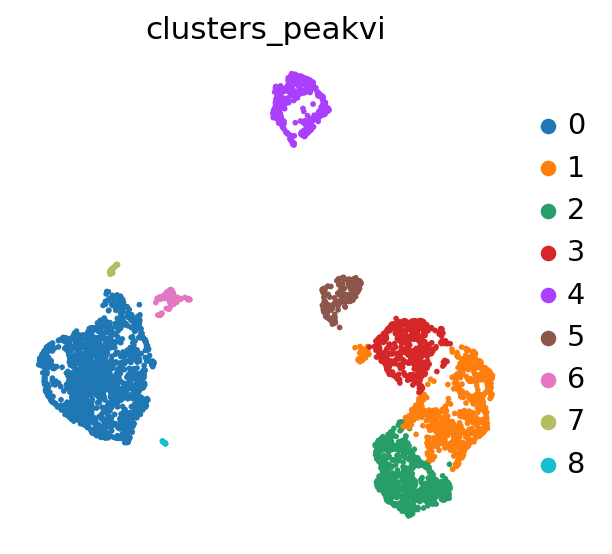

In [14]:
sc.pl.umap(adata, color=PEAKVI_CLUSTERS_KEY)

In [15]:
# (1.1) using a known factor to compare two clusters
## two-sided is True by default, but included here for emphasis
da_res11 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY, group1="3", group2="0", two_sided=True
)

# (1.2) using a known factor to compare a cluster against all other clusters
## if we only provide group1, group2 is all other cells by default
da_res12 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY, group1="3", two_sided=False
)

# (2.1) using indices to compare two clusters
## we can use boolean masks or integer indices for the `idx1` and `idx2` arguments
da_res21 = model.differential_accessibility(
    idx1=adata.obs[PEAKVI_CLUSTERS_KEY] == "3",
    idx2=adata.obs[PEAKVI_CLUSTERS_KEY] == "0",
    two_sided=True,
)
# (2.2) using indices to compare a cluster against all other clusters
## if we don't provide idx2, it uses all other cells as the contrast
da_res22 = model.differential_accessibility(
    idx1=np.where(adata.obs[PEAKVI_CLUSTERS_KEY] == "3"),
    two_sided=False,
)

da_res22.head()

DE...: 100%|██████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr16:23493881-23495402,0.9912,True,4.724163,-0.723711,-0.439719,0.761352,0.037641,0.458256,0.018537
chr12:22562036-22563652,0.9850,True,4.184591,-0.696907,-0.374678,0.778128,0.081220,0.413729,0.039051
chr18:77933028-77933973,0.9838,True,4.106411,-0.590512,-0.289078,0.648417,0.057905,0.317254,0.028176
chr3:169994725-169996073,0.9774,True,3.766946,-0.472330,-0.239727,0.527936,0.055605,0.267161,0.027435
chr5:76028274-76029441,0.9766,True,3.731341,-0.682332,-0.327558,0.766591,0.084259,0.371058,0.043500


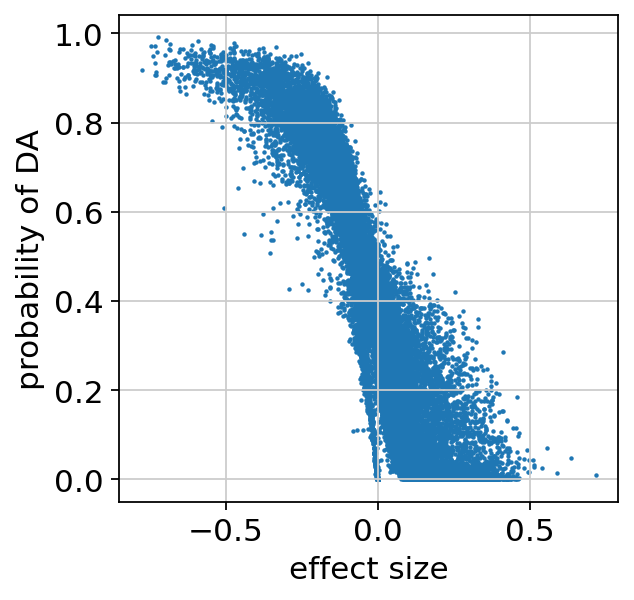

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr16:23493881-23495402,0.9912,True,4.724163,-0.723711,-0.439719,0.761352,0.037641,0.458256,0.018537
chr12:22562036-22563652,0.9850,True,4.184591,-0.696907,-0.374678,0.778128,0.081220,0.413729,0.039051
chr18:77933028-77933973,0.9838,True,4.106411,-0.590512,-0.289078,0.648417,0.057905,0.317254,0.028176
chr3:169994725-169996073,0.9774,True,3.766946,-0.472330,-0.239727,0.527936,0.055605,0.267161,0.027435
chr5:76028274-76029441,0.9766,True,3.731341,-0.682332,-0.327558,0.766591,0.084259,0.371058,0.043500
chr22:27037977-27039956,0.9736,True,3.607636,-0.548299,-0.259050,0.667039,0.118740,0.319109,0.060059
chr11:115373408-115375985,0.9730,True,3.584547,-0.610219,-0.426697,0.834339,0.224120,0.547310,0.120613
chr10:6533499-6534719,0.9720,True,3.547151,-0.746620,-0.384834,0.855148,0.108529,0.439703,0.054869
chr8:101421830-101424198,0.9712,True,3.518157,-0.467588,-0.237140,0.553044,0.085455,0.276438,0.039298
chr10:33406345-33407359,0.9712,True,3.518157,-0.543438,-0.270166,0.624985,0.081546,0.311688,0.041522


In [16]:
plt.scatter(da_res22.effect_size, da_res22.prob_da, s=1)
plt.xlabel("effect size")
plt.ylabel("probability of DA")
plt.show()

da_res22.loc[da_res22.is_da_fdr].sort_values("prob_da", ascending=False).head(10)

In [ ]:
#scBasset tutorial

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
from scib_metrics.benchmark import Benchmarker

sc.set_figure_params(figsize=(4, 4), frameon=False)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read(
    "data/buen_ad_sc.h5ad",
    backup_url="https://storage.googleapis.com/scbasset_tutorial_data/buen_ad_sc.h5ad",
)
adata

AnnData object with n_obs × n_vars = 2034 × 103151
    obs: 'cell_barcode', 'label', 'batch'
    var: 'chr', 'start', 'end', 'n_cells'
    uns: 'label_colors'

In [3]:
BATCH_KEY = "batch"
adata.obs[BATCH_KEY].value_counts()

batch
BM0828    533
BM1077    507
BM1137    402
BM1214    298
BM0106    203
other      91
Name: count, dtype: int64

In [4]:
LABEL_KEY = "label"
adata.obs[LABEL_KEY].value_counts()

label
CMP     502
GMP     402
HSC     347
LMPP    160
MPP     142
pDC     141
MEP     138
CLP      78
mono     64
UNK      60
Name: count, dtype: int64

In [5]:
print("before filtering:", adata.shape)
min_cells = int(adata.n_obs * 0.05)  # threshold: 5% of cells
sc.pp.filter_genes(adata, min_cells=min_cells)  # in-place filtering of regions
print("after filtering:", adata.shape)

before filtering: (2034, 103151)
after filtering: (2034, 33247)


/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [6]:
adata.var.sample(10)

,chr,start,end,n_cells
13409,chr1,154908985,154910325,740
76729,chr15,65165173,65165723,102
23458,chr10,13481684,13482791,157
213277,chr8,30890479,30891804,583
226158,chr9,100616198,100616860,155
96491,chr17,71470402,71470989,237
46397,chr12,497717,498973,398
517,chr1,3566374,3566986,240
191210,chr6,64308153,64308816,115
92406,chr17,35715641,35716756,718


In [7]:
scvi.data.add_dna_sequence(
    adata,
    chr_var_key="chr",
    start_var_key="start",
    end_var_key="end",
    genome_name="hg19",
    genome_dir="data",
)
adata

Working...: 100%|███████████████████████████████| 24/24 [00:00<00:00, 24.72it/s]


/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scvi/data/_preprocessing.py:461: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adata.varm[code_varm_key] = sequence_df.applymap(_dna_to_code)


AnnData object with n_obs × n_vars = 2034 × 33247
    obs: 'cell_barcode', 'label', 'batch'
    var: 'chr', 'start', 'end', 'n_cells'
    uns: 'label_colors'
    varm: 'dna_sequence', 'dna_code'

In [9]:
adata.varm["dna_sequence"]

,0,1,2,3,4,5,6,7,8,9,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
0,N,N,N,N,N,N,N,N,N,N,...,A,G,C,C,G,G,G,C,A,C
3,A,A,G,G,A,C,A,C,T,C,...,C,A,G,A,A,C,A,T,A,C
5,T,T,C,C,C,A,A,T,T,C,...,C,T,T,G,G,T,T,G,T,G
8,A,A,G,A,G,G,T,T,T,A,...,C,C,A,C,C,C,A,G,G,A
9,T,T,T,C,G,T,C,A,T,G,...,A,C,T,G,A,A,A,C,C,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237371,C,T,G,C,A,G,G,C,T,G,...,G,A,C,C,A,G,C,C,T,G
237383,C,T,G,A,T,A,A,G,C,T,...,G,C,T,C,T,T,T,C,T,C
237399,T,A,A,G,C,C,A,T,G,A,...,T,T,T,C,C,T,T,G,T,T
237425,T,T,T,T,T,T,G,C,T,A,...,T,T,G,A,A,G,T,T,T,G


In [10]:
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(
    bdata, layer="binary", dna_code_key="dna_code", batch_key=BATCH_KEY
)

I0000 00:00:1696347330.397641   11940 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


INFO     Using column names from columns of adata.obsm['dna_code']                                                 


In [11]:
model = scvi.external.SCBASSET(bdata, l2_reg_cell_embedding=1e-8)
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCBASSET.setup_anndata` with arguments:

{'dna_code_key': 'dna_code', 'layer': 'binary', 'batch_key': 'batch'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_batch      │   6   │
│     n_cells      │ 33247 │
│    n_dna_code    │ 1344  │
│      n_vars      │ 2034  │
└──────────────────┴───────┘

               Data Registry               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃   scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['binary']  │
│    batch     │ adata.var['_scvi_batch'] │
│   dna_code   │  adata.obsm['dna_code']  │
└──────────────┴──────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.var['batch'] │   BM0106   │          0          │
│                    │   BM0828   │          1          │
│                    │   BM1077   │          2          │
│                    │   BM1137   │          3          │
│                    │   BM1214   │          4          │
│                    │   other    │          5          │
└────────────────────┴────────────┴─────────────────────┘

In [12]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|█| 1000/1000 [3:56:03<00:00, 15.67s/it, v_num=1, train_los

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|█| 1000/1000 [3:56:03<00:00, 14.16s/it, v_num=1, train_los


<Axes: xlabel='epoch'>

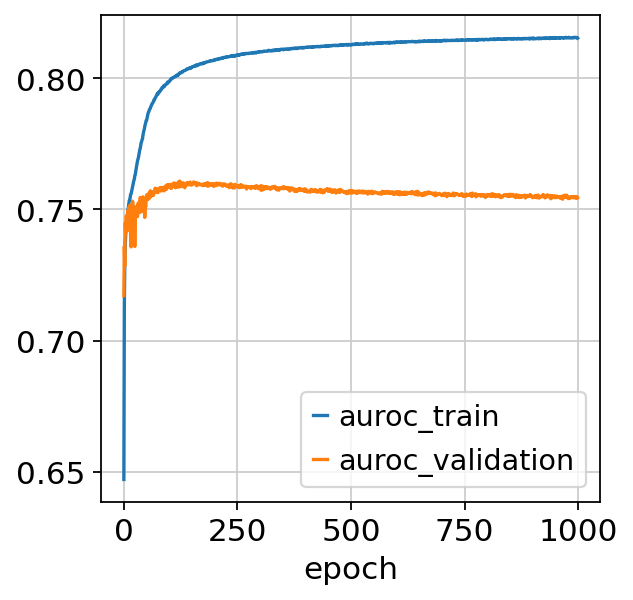

In [13]:
fig, ax = plt.subplots()
model.history_["auroc_train"].plot(ax=ax)
model.history_["auroc_validation"].plot(ax=ax)
#Looks like Epoch 500 is fine!

In [14]:
LATENT_KEY = "X_scbasset"
adata.obsm[LATENT_KEY] = model.get_latent_representation()
adata.obsm[LATENT_KEY].shape

(2034, 32)

In [15]:
sc.pp.neighbors(adata, use_rep=LATENT_KEY)
sc.tl.umap(adata, min_dist=1.0)

2023-10-03 15:45:33.583547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


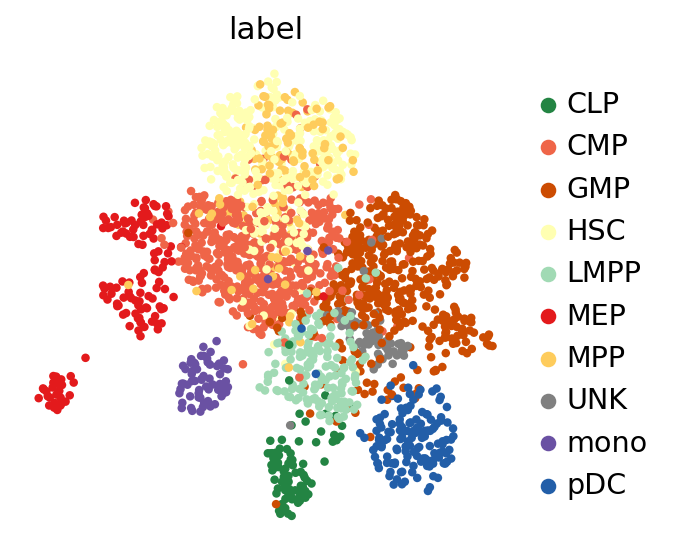

In [16]:
sc.pl.umap(adata, color=LABEL_KEY)

/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


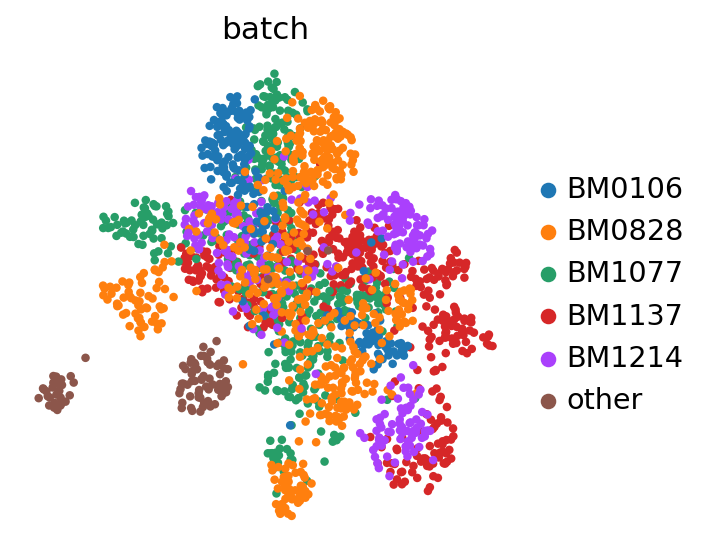

In [17]:
sc.pl.umap(adata, color=BATCH_KEY)

In [18]:
bm = Benchmarker(
    adata,
    batch_key=BATCH_KEY,
    label_key=LABEL_KEY,
    embedding_obsm_keys=[LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

Metrics:   0%|        | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 1 batches per label

Metrics:  10%| | 1/10 [00:00<00:02,  3.50it/s, Bio conservation: isolated_labels
Metrics:  10%| | 1/10 [00:00<00:02,  3.50it/s, Bio conservation: nmi_ari_cluster
Metrics:  20%|▏| 2/10 [00:00<00:03,  2.09it/s, Bio conservation: nmi_ari_cluster
Metrics:  20%|▏| 2/10 [00:00<00:03,  2.09it/s, Bio conservation: silhouette_labe
Metrics:  40%|██▍   | 4/10 [00:01<00:01,  3.42it/s, Bio conservation: clisi_knn]
Metrics:  40%|▍| 4/10 [00:01<00:01,  3.42it/s, Batch correction: silhouette_batc
Metrics:  50%|▌| 5/10 [00:03<00:03,  1.26it/s, Batch correction: silhouette_batc
Metrics:  60%|▌| 6/10 [00:03<00:03,  1.26it/s, Batch correction: kbet_per_label]/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scib_metrics/_kbet.py:187: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() i

INFO     UNK consists of a single batch or is too small. Skip.                                                     
INFO     mono consists of a single batch or is too small. Skip.                                                    



Metrics:  70%|▋| 7/10 [00:06<00:03,  1.13s/it, Batch correction: kbet_per_label]
Metrics:  70%|▋| 7/10 [00:06<00:03,  1.13s/it, Batch correction: graph_connectiv/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:  80%|▊| 8/10 [00:06<00:02,  1.13s/it, Batch correction: pcr_comparison]/home/drdx/babupersonal/ibedev/lib/python3.10/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Embeddings: 100%|█████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]

                                                                                

In [19]:
df = bm.get_results(min_max_scale=False)
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_scbasset,0.572399,0.310886,0.126907,0.515596,0.954224,0.872479,0.115692,0.141572,0.857842,0,0.397517,0.496003,0.456608
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score
